# Introduction

This Jupyter notebook exemplifies how to use the Python module (postProcessEMMARM) upon which the postProcessEMMARM is built.
Alternatively, users may prefer to use the GUI (Graphical User Interface) that allows basic processing to be performed through a visual interface.
However, using the Python module gives full control over the processing and may allow better handling of specific experimental issues.

# Importing modules and initial declarations

In [13]:
#Import libraries directly related to EMM-ARM post processing
import CESSIPy_modRenan as SSI 
from MRPy import MRPy #Library with modal analysis functions
import auxFunctions_postProcessEMMARM as auxEMMARM #Library with auxiliary functions for EMM-ARM post processing

#General Python modules
import numpy as np 
import pandas as pd
from scipy.signal import detrend, welch, resample, decimate, find_peaks
import matplotlib.pyplot as plt

#Module for selecting files
from tkinter import Tk, filedialog

#Module to deal with files from the system
import os

#Module to save heat map variables
from numpy import savez_compressed

#Global variables used for checking, do not modifiy
typeOfProcessing = ['singleFile','batchProcessing']
typeOfSystem = ['uEMMARM','National','old_uEMMARM','RPi']
fileTypes = [('.emm files', '*.emm'), ('text files', '*.txt'), ('CSV files', '*.csv')]

# Global configuration

### General processing info

In [14]:
#File naming option
resultFilePreffix = 'noiseUEMMARM' #Preffix to be added to the beginning of the result file
headerResultFiles = 'TESTE DE FUNCIONAMENTO \n'

# Selection options
selectedProcessing = typeOfProcessing[0] #Options: ['singleFile','batchProcessing']
selectedSystem = typeOfSystem[0] #Options: ['uEMMARM','National','old_uEMMARM','RPi]
desiredChannel = 1  #The channel to be read in the file. 
                    #uEMMARM test files only have one channel per test file, so this is ignored if selectedSystem = 0
                    #National test files may have up to four channels in a single file
                    #RPi test files may have up to "n" channels in a single file (TODO: check last stable version of the system)

#Calibration factor of the sensor used to convert test file reading to g's
#calibrationFactor = 1 #This is for National
calibrationFactor = 1/2400 #This is for commercial ADXL335

# Sampling frequency
samplingFrequencyOriginal=860 #In Hz. Obs.: Not used by uEMMARM, which is based on a fixed duration of measurement session, automatically obtained from test files

#Select whether a heat map shall be saved. Only used in batch analysis, i.e., selectedProcessing=1
#TODO: Implement this in GUI
heatMap_BatchAnalysis = {'save':False, 'frequenciesOfInterest': [8,35]}

### Filter configuration

In [15]:
#Filter configuration
#See documentation about the function
filterConfiguration = { 1: {'filter': 'detrend', 'type': 'linear'},
                        3: {'filter': 'butterworth', 'order': 8, 'type': 'bandpass', 'frequencies': [1,400]}}

### Modal identification methods configuration

In [19]:
#Selection of modal identification methods
modalIdentificationMethod_SingleAnalysis = {'peak-picking':True, 
                                            'BFD':True, 
                                            'EFDD':True, 
                                            'SSI-COV':True}


modalIdentificationMethod_BatchAnalysis =  {'peak-picking':False, 
                                            'BFD':False, 
                                            'EFDD':False, 
                                            'SSI-COV':True}

#======================
#Peak-picking method
#======================
nps = 4096 #Length of window for PSD/FFT. The length of the PSD (how many frequency bins will exist) will always be nps+1
intervalForAveragingHz = 5 #Interval for averaging around the peak for the average peak-picking method

#======================
#BFD method
#======================
fint_BFD = [0.8, 1.2] #This specifies the interval around the peak frequency used to fit the curve in BFD. Specified in % of the peak frequency

#======================
#EFDD method
#======================
fint_EFDD = [0.8, 1.2] #This specifies the interval around the peak frequency used to compute the autocorrelation function in EFDD. Specified in % of the peak frequency
tint = np.array([0,0.2]) #This specifies initial and final time interval used to fit the theoretical autocorrelation function. Specified in seconds

#======================
#SSI-COV Configuration
#======================
numModesToBeConsidered=3 # This variable specifies how many modes will be considered in SSI identification. For standard EMM-ARM, we need only 1 (allegedly if the experiment was correctly performed, it will refer to the first frequency)
i = 60 # number of time lags. From Peeters: The number of block rows i of Href should be such that r i >= nmax, which is the maximum model order.
startingOrderNumber = 2 # The order number by which the SSI method will start
endOrderNumber = 60 # The order number by which the SSI method will end
incrementBetweenOrder = 1 # The increment between each iteration
refs = [0] # reference sensor. This comes from the original module, for general Modal Analysis. EMM-ARM is usually performed with a single accelerometer, and thus refs=[0]. EMM-ARM tests with multiple accelerometers have been made and shown to lead to more precise results. But for now, this implementation is unable to handle them. TODO: support use of multiple accelerometers.
# tolerance for SSI methods
tol = np.array(([0.01,8, 150],     # [allowed_variation, lower_bound, higher_bound]: limits for eigenfrequencies
                [0.10,0.001,0.025],   # [allowed_variation, lower_bound, higher_bound]: limits for damping ratios
                [0.02,0,1]))        # [allowed_variation, lower_bound, higher_bound]: limits for MAC


#TODO: implement support for SSI-DATA method

#TODO: implement support for Instrumental Variable Method (IV) method

#Base configuration for plot
plotGeneral = {'frequencyBandOfInterest': [15,120], 'lowerYFactorPlotPSD': 0.8, 'upperYFactorPlotPSD': 1.2, 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'dpi': 150}

plotPSD = {'typeForPSD':'Single_PSD'} #The only option currently supported
plotNPSD = {'typeForANPSD':'only_ANPSD','figSizeANPSD': (5,5)} #The only option currently supported

plotPeakPicking={'typeForPeakPicking': True,'figSizePeakPicking': (5,5)}

plotBFD={'typeForBFD':True, 'figSizeBFD': (5,5)}

plotEFDD={'typeForEFDD-AutocorrelationFitting':True,'typeForEFDD': 'Autocorrelation-SVD','figSizeEFDD': (5,5)} #'typeForEFDD': 'Autocorrelation-SVD' is the only option currently supported option

plotSSI={'typeForStabilizationDiagram': 'StabilizationPSD', 'figSizeStabilization': (5,7)}


plotConfiguration = {}
plotConfiguration.update(plotGeneral)
plotConfiguration.update(plotPSD)
plotConfiguration.update(plotNPSD)
plotConfiguration.update(plotPeakPicking)
plotConfiguration.update(plotBFD)
plotConfiguration.update(plotEFDD)
plotConfiguration.update(plotSSI)


'''
plotConfiguration={'typeForANPSD':'only_ANPSD','typeForPeakPicking': True,'typeForPSD': 'Single_PSD', 'frequencyBandOfInterest': [15,400], 'lowerYFactorPlotPSD': 0.8, 'upperYFactorPlotPSD': 1.2, 'typeForBFD':True, 'typeForEFDD-AutocorrelationFitting':True,'typeForEFDD': 'Autocorrelation-SVD', 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'figSizeANPSD': (5,5),'figSizePeakPicking': (5,5), 'figSizeBFD': (5,5), 'figSizeEFDD': (5,5), 'typeForStabilizationDiagram': 'StabilizationPSD', 'figSizeStabilization': (5,7), 'dpi': 150}
'''

plotConfiguration_Batch={'typeForPSD': False, 'frequencyBandOfInterest': [0,100], 'ylimForPSD': [1e-10,None], 'typeForEFDD': False, 'ylimForEFDD': [None,1], 'typeForBFD':False, 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'figSizeBFD': (5,5), 'figSizeEFDD': (5,5), 'typeForStabilizationDiagram': False, 'figSizeStabilization': (7,7), 'dpi': 150}


### Validation of variables

In [17]:
# Define the type of file to be read
if selectedSystem == "uEMMARM":
    selectedFileType = fileTypes[0]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "National":
    selectedFileType = fileTypes[1]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "old_uEMMARM":
    selectedFileType = fileTypes[1]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "RPi":
    selectedFileType = fileTypes[2]
    selectedFileExtension = selectedFileType[1][-4:]

# Validation of numberChannels variable
if selectedSystem == "uEMMARM":
    desiredChannel = 1
elif selectedSystem == "old_uEMMARM":
    desiredChannel = 1

# Modal identification

## Single file processing

Acceleration time series:


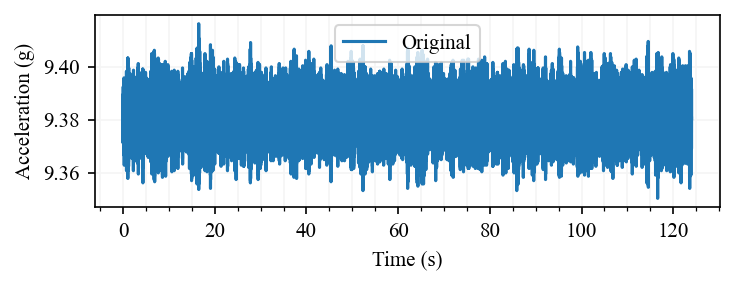

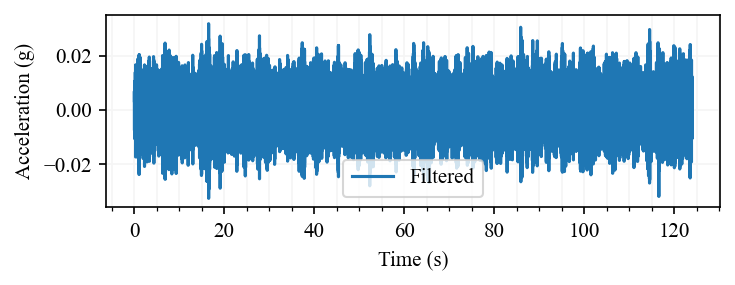

Power Spectral Density estimate:


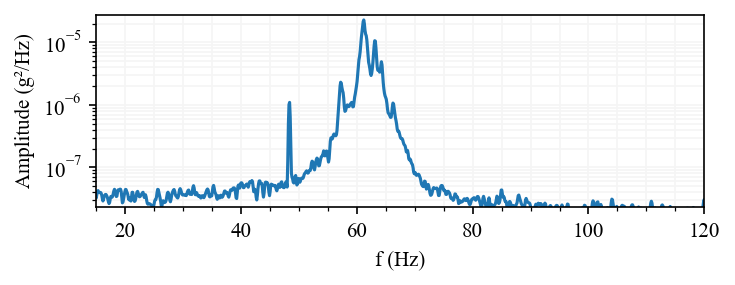

PEAK-PICKING METHOD
RESULTS FROM AVERAGED PEAK-PICKING METHOD
Peak selected as *reference* peak for the averaged peak-picking method:
61.204 Hz
Considering an interval around *reference* peak of 5.000 Hz.
Averaged peak-picking estimated frequency:
61.654 Hz
Half-power bandwidth damping:
1.126 %
END OF RESULTS FROM AVERAGED PEAK-PICKING METHOD


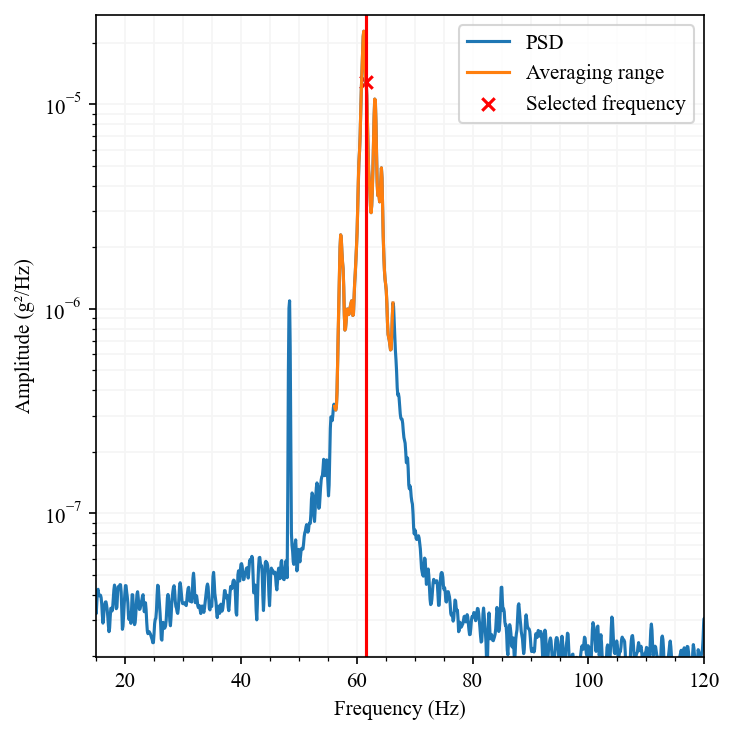

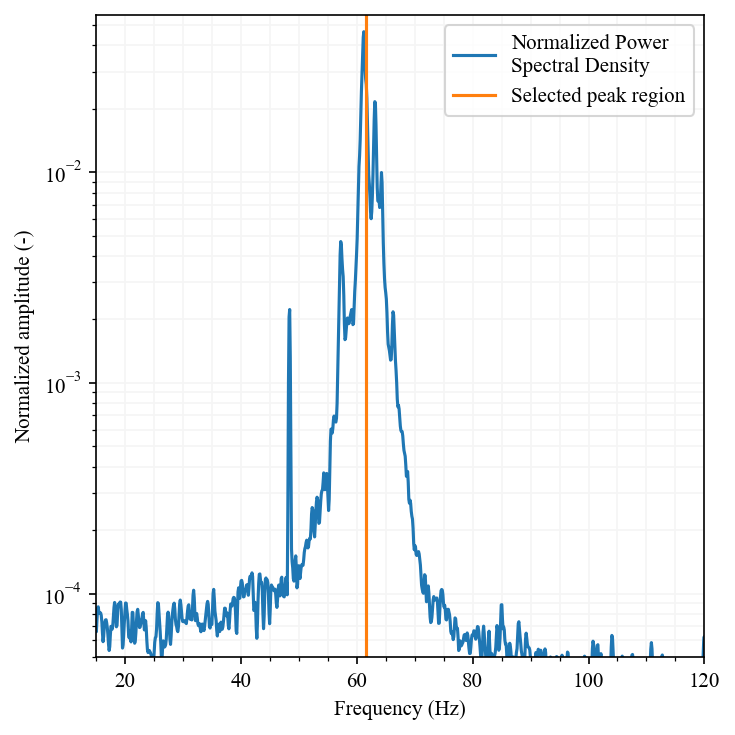

BFD METHOD
RESULTS FROM BFD METHOD
Frequencies identified:
#1: 61.228 Hz
Damping ratios identified:
#1: 0.928 %
END OF RESULTS FROM BFD METHOD


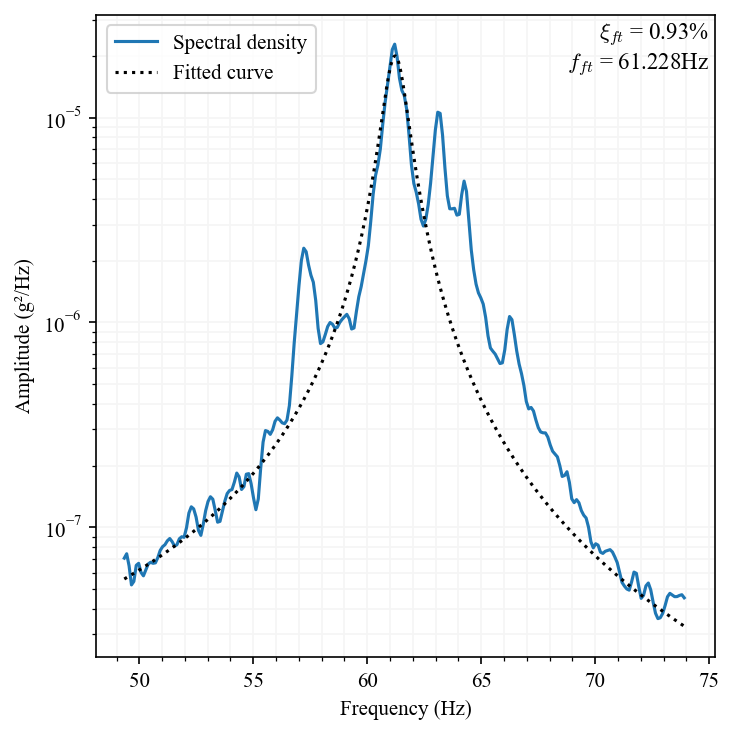

EFDD METHOD
RESULTS FROM EFDD METHOD
Frequencies identified:
#1: 61.677 Hz
Damping ratios:
#1: 1.794 %
END OF RESULTS FROM BFD METHOD


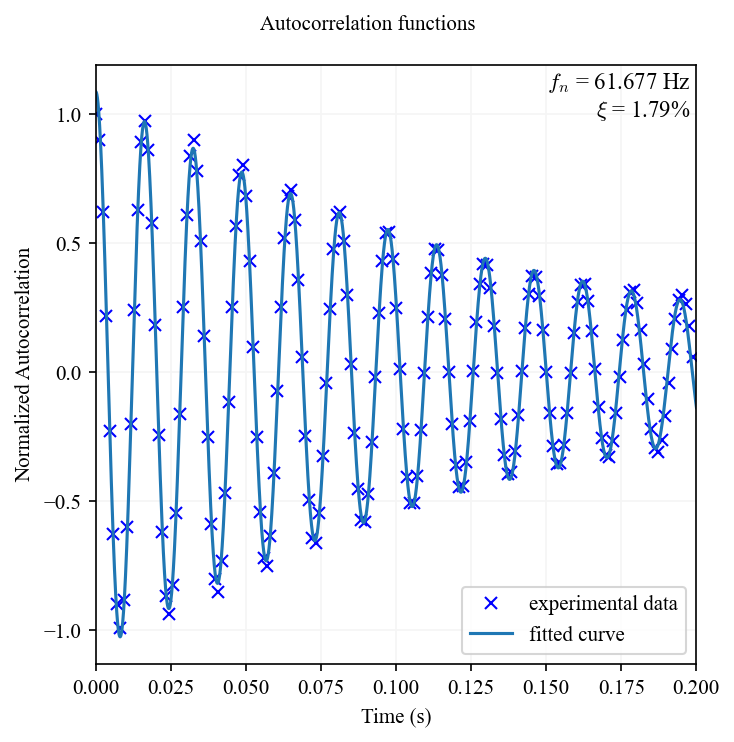

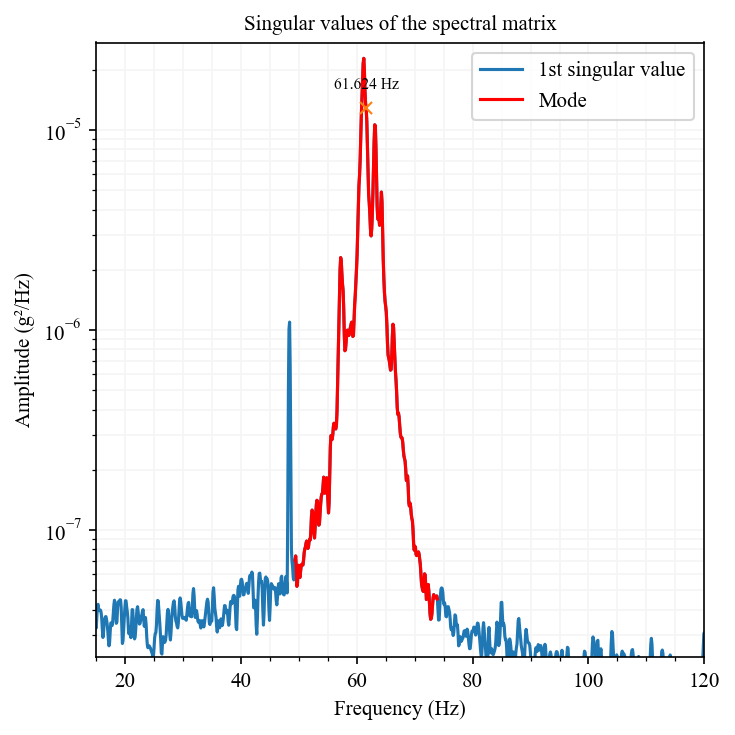

SSI-COV METHOD
RESULTS FROM SSI METHOD
Frequencies identified (in an ordered way):
#1: 61.598 Hz
#2: 145.674 Hz
#3: 145.819 Hz
Damping ratios:
#1: 2.074 %
#2: 0.709 %
#3: 0.725 %
Number of stable poles:
#1: 110
#2: 68
#3: 64
END OF RESULTS FROM SSI METHOD


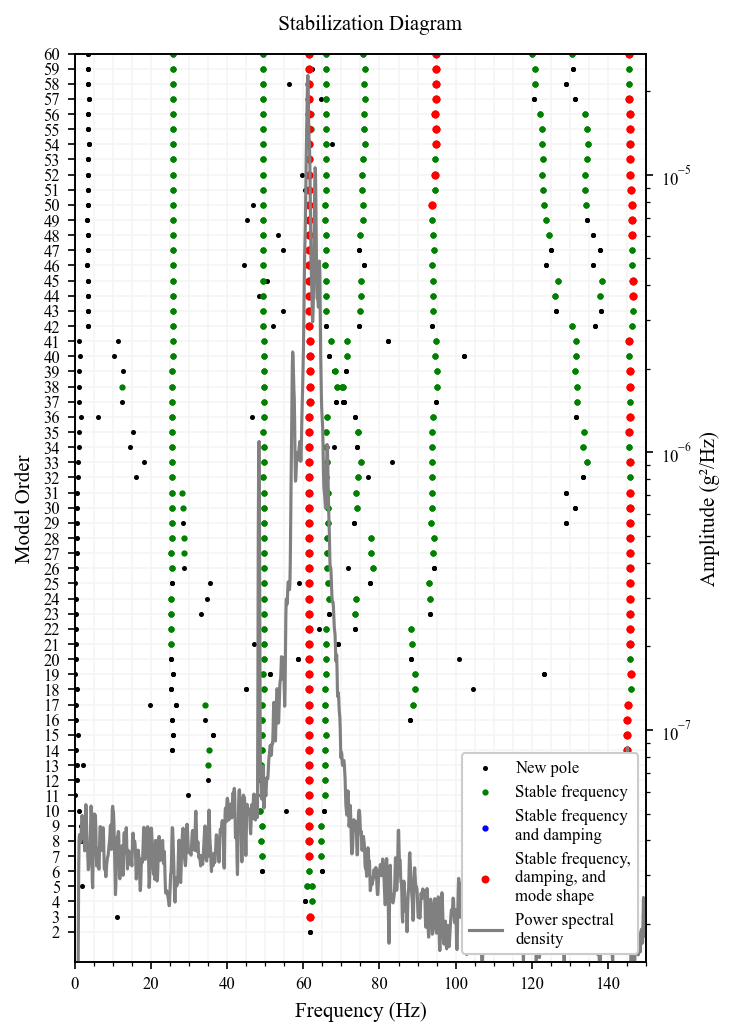

In [20]:
#TODO: Implement sampling frequency obtainment specially for uEMMARM

#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.

if selectedProcessing == 'singleFile':
    ##=======================================================================
    ## READ FILE
    ##=======================================================================
    #DESCRIPTION: read the acceleration time series file
    # Get the path of the file to be read
    pathForFile = filedialog.askopenfile(title="Select test file", filetypes=[selectedFileType])
    #Read file and store in a np.array
    accelerationDigital = auxEMMARM.readSingleFile(pathForFile, selectedSystem, desiredChannel)
    
    ##=======================================================================
    ## PRE-PROCESSING
    ##=======================================================================
    #DESCRIPTION: Pre-processing tasks on the acceleration time series
    # Convert to G's
    acceleration = auxEMMARM.convertToG(accelerationDigital,calibrationFactor)
    #Apply filter
    accelerationFiltered, samplingFrequencyFiltered  = auxEMMARM.filtering(acceleration, samplingFrequencyOriginal, filterConfiguration)
    
    ##=======================================================================
    ## VISUALIZING TIME SERIES AND POWER SPECTRAL DENSITY
    ##=======================================================================
    #DESCRIPTION: Plot acceleration time series
    '''
    auxEMMARM.plotAccelerationTimeSeries([[accelerationFiltered,samplingFrequencyFiltered,'Filtered'],
                                            [acceleration,samplingFrequencyOriginal,'Original']])
                                            '''
    print("Acceleration time series:")
    auxEMMARM.plotAccelerationTimeSeries([[acceleration,samplingFrequencyOriginal,'Original'],], plot=plotConfiguration)
    auxEMMARM.plotAccelerationTimeSeries([[accelerationFiltered,samplingFrequencyFiltered,'Filtered'],], plot=plotConfiguration)
    #Plot Power Spectral Density estimate
    #Convert acceleration to MRPy object, which is used by CESSI.py library.
    yk = MRPy(accelerationFiltered,fs=samplingFrequencyFiltered)
    #Calculate PSD and plot it
    print("Power Spectral Density estimate:")
    PSD = SSI.SDM(yk, nperseg=nps, plot=plotConfiguration, window='hann', nfft=2*nps) #Default is 50% overlap, not configurable in CESSI.py
    
    ##=======================================================================
    ## START THE MODAL IDENTIFICATION METHODS
    ##=======================================================================
    #DESCRIPTION: apply modal identification methods to estimate frequency and damping

    #1) PEAK-PICKING METHOD
    ###DESCRIPTION: This is also used to estimate a preliminar peak to start the EFDD guess process
    ###VARIABLE DESCRIPTION:
    #FFP is a np array that contains the first frequency identified with the averaged peak-picking method (frequencies around the highest peak in the PSD, accordingly tot he parameter are averaged by weighting their respective PSD amplitudes)
    #PSDAveragedFrequency is a float64 number that contains the frequency in the original spectrum closest to the FFP
    #PSDAveragePeakIndex contains the index associated to the frequency contained in PSDAveragedFrequency
    #yMaxPeakIndex contains the index associated to the first peak identified in the peak-picking (the highest peak in the PSD)
    print("===================")
    print("PEAK-PICKING METHOD")
    if modalIdentificationMethod_SingleAnalysis['peak-picking']==True:
        FPP, ZPP_HP, PSDAveragedFrequency, PSDAveragedPeakIndex, yMaxPeakIndex=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, plot=plotConfiguration, verbose=True)
    else:
        FPP, ZPP_HP, ignoreThis, PSDAveragedPeakIndex, ignoreThis=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, plot=plotConfiguration, verbose=True)

    #2) MAKE ALL SORTS OF COMPUTATIONS TO PREPARE FOR FURTHER COMPUTATIONS
    ###DESCRIPTION: Populate the parameters of the PSD object with inputs required by other identification methods when used in the batch mode
    PSD.pki  = np.array([PSDAveragedPeakIndex], dtype=int)
    PSD.MGi  = np.array([0], dtype=int)
    PSD.svi  = np.array([0], dtype=int)
    PSD.tint = tint
    #Plot the ANPSD. This will populate PSD variable with ANPSD and pki variables
    PSD = SSI.ANPSD_from_SDM(PSD,plot=plotConfiguration, mode="batch")
    plt.show()

    #3) PERFORM BFD METHOD
    ###DESCRIPTION: Estimate frequency from curve fitting, and damping from both curve fitting and half-power damping
    ###VARIABLE DESCRIPTION:
    #FBFD is a ndarray containing all the frequencies identified with the BFD method
    #ZBFD_HP holds estimates from 1/2 power method 
    #ZBFD_FT holds for fitting method
    #VBFD holds arrays with the mode shapes associated to each frequency
    #PSD_BFD returns a PSD object with all the relevant attributes obtained from BFD already populated
    print("===================")
    print("BFD METHOD")
    PSD.fint = np.array([fint_BFD[0]*FPP, fint_BFD[1]*FPP])
    if modalIdentificationMethod_SingleAnalysis['BFD']==True:
        FBFD, ZBFD_FT, VBFD, PSD_BFD = SSI.BFD(yk, PSD, plot=plotConfiguration, mode='batch', verbose=True)
    plt.show()

    #4) EFDD METHOD
    ###DESCRIPTION: Perform EFDD method, that is based on the autocorrelation function and SVD decomposition
    ###VARIABLE DESCRIPTION:
    #FEFDD is a ndarray containing Eigenfrequencies array
    #ZEFDD is a list containing damping ratios
    #VEFDD is a ndarray contaning all mode shapes as columns
    #PSD_EFDD is an auxclass_like object that contains the attributes used in the method (pki, svi, fint, tint)
    print("===================")
    print("EFDD METHOD")
    PSD.fint = np.array([fint_EFDD[0]*FPP, fint_EFDD[1]*FPP])
    if modalIdentificationMethod_SingleAnalysis['EFDD']==True:
        FEFDD, ZEFDD, VEFDD, PSD_EFDD = SSI.EFDD(yk, PSD, plot=plotConfiguration, mode='batch', verbose=True)
    plt.show()
    
    #5) PERFORM SSI-COV METHOD
    print("===================")
    print("SSI-COV METHOD")
    if modalIdentificationMethod_SingleAnalysis['SSI-COV']==True:
        ##5.1) PREPARE DATA
        ###DESCRIPTION: Adjusted time series for SSI method
        yk = SSI.rearrange_data(yk,refs) 

        ##5.2) SSI_COV_ITERATOR
        ###DESCRIPTION: SSI_COV_iterator estimates eigenfrequencies, damping ratios, and mode shape for each model order specified in the algorithm (starting at startingOrderNumber, finishing at endOrderNumber, each incrementBetweenOrder)
        ###VARIABLE DESCRIPTION:
        #FSSI_MODEL holds all eigenfrequencies of all models
        #ZSSI_MODEL holds all damping ratios of all models
        #VSSI_MODEL holds all mode shapes of all models
        FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL = SSI.SSI_COV_iterator(yk,i,startingOrderNumber, endOrderNumber, incrementBetweenOrder, plot=False)
        
        ##5.3) STABILIZATION_DIAGRAM
        ###DESCRIPTION: stabilization_diagram will apply the stabilization diagram method on the models obtained previously, classifiying each eigenvalue as "new pole", "stable frequency", "stable frequency and damping", "stable frequency, damping and mode shape". This last class of poles are those considered stables.
        ###VARIABLE DESCRIPTION:
        #stbC is a ndaray containing False or True for all poles considered stable, for every model order.
        stableModes = SSI.stabilization_diagram(FSSI_MODEL,ZSSI_MODEL,VSSI_MODEL, tol=tol, plot=plotConfiguration, PSD=PSD, verbose=False)

        ##5.4) SIMPLIFIED CLUSTER ANALYSIS
        ###5.4.1) CLUSTERIZE MODES
        ###DESCRIPTION: simplified cluster analysis, which will gather close modes together based on the tolerance settings 
        ###VARIABLE DESCRIPTION:
        #FSSI is a ndarray that contains all the frequencies associated to each model
        #ZSSI is a ndarray that contains all the dampings associated to each model
        #VSSI is a ndarray that contains all the mode shapes associated to each model
        #numStablePoles is a ndarray that contains the number of stable poles associated to each clusterized stable pole
        FSSI, ZSSI, VSSI, numStablePoles = SSI.stable_modes(FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL, stableModes, tol=0.01, spo=10, verbose=True)
        ###5.4.2) ORGANIZE THE RESULTS
        ###DESCRIPTION: the previous function was implemented for the general purpose of CESSI.py library. This will organize the results for EMM-ARM purpose
        FSSI_CLUSTER=np.zeros(numModesToBeConsidered)
        ZSSI_CLUSTER=np.zeros(numModesToBeConsidered)
        numStablePoles_CLUSTER=np.zeros(numModesToBeConsidered)
        eigenfrequenciesIndices = np.flip(np.argsort(numStablePoles))
        
        if FSSI.size == 0:
            print('No sufficiently large frequency clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(FSSI, eigenfrequenciesIndices, 0)[0:3]): FSSI_CLUSTER[r]=l

        if ZSSI.size == 0:
            print('No sufficiently large damping clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(ZSSI, eigenfrequenciesIndices, 0)[0:3]): ZSSI_CLUSTER[r]=100*l
        
        if numStablePoles.size == 0:
            print('No sufficiently large clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(numStablePoles, eigenfrequenciesIndices, 0)[0:3]): numStablePoles_CLUSTER[r]=int(l)
        

## Batch processing

In [ ]:
#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.

#Initialize correction variables
ageCorrectionFactor = 0
flagForCorrection = False

#Inititalize temperature and humidity variables

if selectedProcessing == 'batchProcessing':
    #Get the path of the folder containing the file to be read
    folderPath = filedialog.askdirectory(title="Select directory with test files") # Returns opened path as str
    filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == selectedFileExtension] #Get array with file names
    #filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == '.EMM'] #Get array with file names

    #Create a holder to store the time instant of each measurement
    agesOfMeasurementOriginal = np.zeros(len(filesToRead)) #This will store the original ages as per registered during test (with all the issues of interruption and restarting)
    agesOfMeasurementCorrected = np.zeros(len(filesToRead)) #This will store corrected ages (already accounting for interruption and restarting issues)
    

    #Create holders for frequency and damping for each modal identification method
    if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
        FPP = np.zeros(len(filesToRead))
        ZPP_HP = np.zeros(len(filesToRead)) #To hold half-power bandwitdh
    if modalIdentificationMethod_BatchAnalysis['BFD']==True:
        FBFD = np.zeros(len(filesToRead))
        ZBFD_FT = np.zeros(len(filesToRead)) #To hold curve fitting
    if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
        FEFDD = np.zeros(len(filesToRead))
        ZEFDD = np.zeros(len(filesToRead))
    if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
        numStablePoles_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
        FSSI_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
        ZSSI_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
        
    #Repeat for every file
    for iteration, files in enumerate(filesToRead):
        ##=======================================================================
        ## READ FILE
        ##=======================================================================
        #DESCRIPTION: read the acceleration time series file and get the time of measurement
        #Read file and store in a np.array
        accelerationDigital = auxEMMARM.readBatchFile(folderPath, files, selectedSystem, desiredChannel)
        agesOfMeasurementOriginal[iteration] = auxEMMARM.getAgeAtMeasurementBatchFile(folderPath, files, filesToRead[0], selectedSystem)
        
        #Check if correction is needed due system restart in the middle of the experiment
        if agesOfMeasurementOriginal[iteration]<agesOfMeasurementOriginal[iteration-1]:
            flagForCorrection = True #This indicatae a time correction needs to be performed from now on
            
            ageCorrectionFactor = ageCorrectionFactor+2*agesOfMeasurementCorrected[iteration-1]-agesOfMeasurementCorrected[iteration-2] #This will be the factor that will be added to all the posterior ages. We need to add all the age occured until the last correctly registered session, and a time gap (that we dont know the value because it wasnt properly registered as the series restrated). This unknown time gap is estimated as the same time gap between the two last properly measured sessions.

            #This is an additional correction factor only for batch 2 on uEMMARM: after the 5th iteration, the system remained off for 2700 seconds until a correction was made
            if ((iteration == 6) and (headerResultFiles == '2ND BATCH PAPER UEMMARM \n')):
                ageCorrectionFactor = ageCorrectionFactor + 2700
        #Apply correction if it exists
        if flagForCorrection == True:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]+ageCorrectionFactor
        else:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]
            
        ##=======================================================================
        ## PRE-PROCESSING
        ##=======================================================================
        #DESCRIPTION: Pre-processing tasks on the acceleration time series
        # Convert to G's
        acceleration = auxEMMARM.convertToG(accelerationDigital,calibrationFactor)
        #Get sampling frequency
        if selectedSystem == 'uEMMARM':
            samplingFrequency = auxEMMARM.getSamplingFrequency_uEMMARM(folderPath, files, len(acceleration))
        else:
            samplingFrequency = samplingFrequencyOriginal
        
        #Apply filter
        accelerationFiltered, samplingFrequencyFiltered  = auxEMMARM.filtering(acceleration, samplingFrequency, filterConfiguration)
        
        ##=======================================================================
        ## VISUALIZING TIME SERIES AND POWER SPECTRAL DENSITY
        ##=======================================================================
        #DESCRIPTION: Plot acceleration time series
        #Plot Power Spectral Density estimate
        #Convert acceleration to MRPy object, which is used by CESSI.py library.
        yk = MRPy(accelerationFiltered,samplingFrequencyFiltered)
        #Calculate PSD and plot it
        PSD = SSI.SDM(yk, nperseg=nps, plot=plotConfiguration_Batch, window='hann', nfft=2*nps) #Default is 50% overlap, not configurable in CESSI.py
        
        ##=======================================================================
        ## START THE MODAL IDENTIFICATION METHODS
        ##=======================================================================
        #DESCRIPTION: apply modal identification methods to estimate frequency and damping

        #1) PEAK-PICKING METHOD
        ###DESCRIPTION: This is also used to estimate a preliminar peak to start the EFDD guess process
        ###VARIABLE DESCRIPTION:
        #FFP is a np array that contains the first frequency identified with the averaged peak-picking method (frequencies around the highest peak in the PSD, accordingly tot he parameter are averaged by weighting their respective PSD amplitudes)
        #PSDAveragedFrequency is a float64 number that contains the frequency in the original spectrum closest to the FFP
        #PSDAveragePeakIndex contains the index associated to the frequency contained in PSDAveragedFrequency
        #yMaxPeakIndex contains the index associated to the first peak identified in the peak-picking (the highest peak in the PSD)
        if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
            FPP[iteration], ZPP_HP[iteration], PSDAveragedFrequency, PSDAveragedPeakIndex, yMaxPeakIndex=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose=False)
            PSD.fint = np.array([fint_BFD[0]*FPP[iteration], fint_BFD[1]*FPP[iteration]])
        else:
            FPP, ZPP_HP[iteration], ignoreThis, PSDAveragedPeakIndex, ignoreThis=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose=False)
            PSD.fint = np.array([fint_BFD[0]*FPP, fint_BFD[1]*FPP])

        #2) MAKE ALL SORTS OF COMPUTATIONS TO PREPARE FOR FURTHER COMPUTATIONS
        ###DESCRIPTION: Populate the parameters of the PSD object with inputs required by other identification methods when used in the batch mode
        PSD.pki  = np.array([PSDAveragedPeakIndex], dtype=int)
        PSD.MGi  = np.array([0], dtype=int)
        PSD.svi  = np.array([0], dtype=int)
        PSD.tint = tint
        #Plot the ANPSD. This will populate PSD variable with ANPSD and pki variables
        PSD = SSI.ANPSD_from_SDM(PSD,plot=plotConfiguration_Batch, mode="batch")

        #3) PERFORM BFD METHOD
        ###DESCRIPTION: Estimate frequency from curve fitting, and damping from both curve fitting and half-power damping
        ###VARIABLE DESCRIPTION:
        #FBFD is a ndarray containing all the frequencies identified with the BFD method
        #ZBFD is a list containing the damping ratios associated to each frequency: ZBFD(0) holds estimates from 1/2 power method and ZBFD(1) holds for fitting method
        #VBFD holds arrays with the mode shapes associated to each frequency
        #PSD_BFD returns a PSD object with all the relevant attributes obtained from BFD already populated
        if modalIdentificationMethod_BatchAnalysis['BFD']==True:
            FBFD[iteration], ZBFD_FT[iteration], VBFD, PSD_BFD = SSI.BFD(yk, PSD, plot=plotConfiguration_Batch, mode='batch', verbose=False)
            #ZBFD[iteration,:]
        
        #4) EFDD METHOD
        ###DESCRIPTION: Perform EFDD method, that is based on the autocorrelation function and SVD decomposition
        ###VARIABLE DESCRIPTION:
        #FEFDD is a ndarray containing Eigenfrequencies array
        #ZEFDD is a list containing damping ratios
        #VEFDD is a ndarray contaning all mode shapes as columns
        #PSD_EFDD is an auxclass_like object that contains the attributes used in the method (pki, svi, fint, tint)
        if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
            PSD.fint = np.array([fint_EFDD[0]*FPP[iteration], fint_EFDD[1]*FPP[iteration]])
        else:
            PSD.fint = np.array([fint_EFDD[0]*FPP, fint_EFDD[1]*FPP])
        if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
            FEFDD[iteration], ZEFDD[iteration], VEFDD, PSD_EFDD = SSI.EFDD(yk, PSD, plot=plotConfiguration_Batch, mode='batch', verbose=False)

        #5) PERFORM SSI-COV METHOD
        if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
            ##5.1) PREPARE DATA
            ###DESCRIPTION: Adjusted time series for SSI method
            yk = SSI.rearrange_data(yk,refs) 

            ##5.2) SSI_COV_ITERATOR
            ###DESCRIPTION: SSI_COV_iterator estimates eigenfrequencies, damping ratios, and mode shape for each model order specified in the algorithm (starting at startingOrderNumber, finishing at endOrderNumber, each incrementBetweenOrder)
            ###VARIABLE DESCRIPTION:
            #FSSI_MODEL holds all eigenfrequencies of all models
            #ZSSI_MODEL holds all damping ratios of all models
            #VSSI_MODEL holds all mode shapes of all models
            FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL = SSI.SSI_COV_iterator(yk,i,startingOrderNumber, endOrderNumber, incrementBetweenOrder, plot=False)
            
            ##5.3) STABILIZATION_DIAGRAM
            ###DESCRIPTION: stabilization_diagram will apply the stabilization diagram method on the models obtained previously, classifiying each eigenvalue as "new pole", "stable frequency", "stable frequency and damping", "stable frequency, damping and mode shape". This last class of poles are those considered stables.
            ###VARIABLE DESCRIPTION:
            #stbC is a ndaray containing False or True for all poles considered stable, for every model order.
            stableModes = SSI.stabilization_diagram(FSSI_MODEL,ZSSI_MODEL,VSSI_MODEL, tol=tol, plot=plotConfiguration_Batch, PSD=PSD, verbose=False)

            ##5.4) SIMPLIFIED CLUSTER ANALYSIS
            ###5.4.1) CLUSTERIZE MODES
            ###DESCRIPTION: simplified cluster analysis, which will gather close modes together based on the tolerance settings 
            ###VARIABLE DESCRIPTION:
            #FSSI is a ndarray that contains all the frequencies associated to each model
            #ZSSI is a ndarray that contains all the dampings associated to each model
            #VSSI is a ndarray that contains all the mode shapes associated to each model
            #numStablePoles is a ndarray that contains the number of stable poles associated to each clusterized stable pole
            FSSI, ZSSI, VSSI, numStablePoles = SSI.stable_modes(FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL, stableModes, tol=0.01, spo=10, verbose=False)
            ###5.4.2) ORGANIZE THE RESULTS
            ###DESCRIPTION: the previous function was implemented for the general purpose of CESSI.py library. This will organize the results for EMM-ARM purpose
            eigenfrequenciesIndices = np.flip(np.argsort(numStablePoles))
            for r, l in enumerate(np.take_along_axis(FSSI, eigenfrequenciesIndices, 0)[0:3]): FSSI_CLUSTER[iteration][r]=l
            for r, l in enumerate(np.take_along_axis(ZSSI, eigenfrequenciesIndices, 0)[0:3]): ZSSI_CLUSTER[iteration][r]=100*l
            for r, l in enumerate(np.take_along_axis(numStablePoles, eigenfrequenciesIndices, 0)[0:3]): numStablePoles_CLUSTER[iteration][r]=int(l)

        #6) POPULATE HEAT MAPA VARIABLE
        if heatMap_BatchAnalysis['save'] == True:
            if iteration == 0:
                #The heatMap variable will be a 2D numpy array to store all PSDs in a organized way to plot a heat map of the EMM-ARM test
                #The first row will contain the ages associated to each PSD
                #The first column will contain the frequency bins of each PSD (they will be the same as all PSDs are processed in the same way)
                #The number of frequency bins will depend on the specified frequencies of interest.
                #The first element will contain a np.nan, as it will not contain anything meaningful (it is just the crossing of the row with ages and column with frequency bins)

                #First, check if it is the first iteration, populate the first column (with the frequency bins)
                indicesOfInterest=np.where(np.logical_and(PSD.f>=heatMap_BatchAnalysis['frequenciesOfInterest'][0], PSD.f<=heatMap_BatchAnalysis['frequenciesOfInterest'][1]))
                heatMap=np.zeros((len(indicesOfInterest[0])+1,len(filesToRead)+1))
                heatMap[0,0]=np.nan
                heatMap[1:,0]=PSD.f[indicesOfInterest] #Remember that first row is dedicated for age associated to the PSDs
            #Now, populate the next column with PSD
            #If iteration = n, then the respective colum in heatMapa is n+1, as the first column is already populated by frequency bins)
            heatMap[1:, iteration+1]=PSD.ANPSD[indicesOfInterest]
            #Populate the first element of the current column being populated with the associated age of the PSD
            heatMap[0, iteration+1]=agesOfMeasurementCorrected[iteration]
    
    #Generate result files with the modal identification
    if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
        np.savetxt(resultFilePreffix+'_Frequency_PP.txt', np.vstack((agesOfMeasurementCorrected, FPP)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
    if modalIdentificationMethod_BatchAnalysis['BFD']==True:
        np.savetxt(resultFilePreffix+'_Frequency_BFD.txt', np.vstack((agesOfMeasurementCorrected, FBFD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
        np.savetxt(resultFilePreffix+'_Damping_HP_BFD.txt', np.vstack((agesOfMeasurementCorrected, ZBFD_HP)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tHALF-POWER DAMPING RATIO(%)")
        np.savetxt(resultFilePreffix+'_Damping_FT_BFD.txt', np.vstack((agesOfMeasurementCorrected, ZBFD_FT)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFITTING DAMPING RATIO(%)")
    if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
        np.savetxt(resultFilePreffix+'_Frequency_EFFD.txt', np.vstack((agesOfMeasurementCorrected, FEFDD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
        np.savetxt(resultFilePreffix+'_Damping_EFFD.txt', np.vstack((agesOfMeasurementCorrected, ZEFDD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tDAMPING RATIO(%)")
    if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
        np.savetxt(resultFilePreffix+'_Frequency_SSI.txt', np.vstack((agesOfMeasurementCorrected, FSSI_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCIES(%)")
        np.savetxt(resultFilePreffix+'_Damping_SSI.txt', np.vstack((agesOfMeasurementCorrected, ZSSI_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tDAMPING RATIOS(%)")
        np.savetxt(resultFilePreffix+'_numPoles_SSI.txt', np.vstack((agesOfMeasurementCorrected, numStablePoles_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tNUMBER POLES(%)")  
    if  heatMap_BatchAnalysis['save'] == True:
        savez_compressed(resultFilePreffix+'_'+headerResultFiles[0:3]+'_heatMap.npz', heatMap)     

import winsound
duration = 500  # milliseconds
freq = 800  # Hz
winsound.Beep(freq, duration)

## Get temperature and humidity history only

In [ ]:
#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.

#Initialize correction variables
ageCorrectionFactor = 0
flagForCorrection = False

#Inititalize temperature and humidity variables

if selectedProcessing == 'onlyTemperatureHumidityHistory':
    #Get the path of the folder containing the file to be read
    folderPath = filedialog.askdirectory(title="Select directory with test files") # Returns opened path as str
    filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == selectedFileExtension] #Get array with file names
    #filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == '.EMM'] #Get array with file names

    #Create a holder to store the time instant of each measurement
    agesOfMeasurementOriginal = np.zeros(len(filesToRead)) #This will store the original ages as per registered during test (with all the issues of interruption and restarting)
    agesOfMeasurementCorrected = np.zeros(len(filesToRead)) #This will store corrected ages (already accounting for interruption and restarting issues)
    
    #Create holders for frequency and damping for each modal identification method
    temperature = np.zeros(len(filesToRead))
    humidity = np.zeros(len(filesToRead))
    
    #Repeat for every file
    for iteration, files in enumerate(filesToRead):
        ##=======================================================================
        ## READ FILE
        ##=======================================================================
        #DESCRIPTION: read the acceleration time series file and get the time of measurement
        #Read file and store in a np.array
        [temperature[iteration], humidity[iteration]] = auxEMMARM.getTemperatureHumidity_uEMMARM(folderPath, files)
        agesOfMeasurementOriginal[iteration] = auxEMMARM.getAgeAtMeasurementBatchFile(folderPath, files, filesToRead[0], selectedSystem)
        
        #Check if correction is needed due system restart in the middle of the experiment
        if agesOfMeasurementOriginal[iteration]<agesOfMeasurementOriginal[iteration-1]:
            flagForCorrection = True #This indicatae a time correction needs to be performed from now on
            
            ageCorrectionFactor = ageCorrectionFactor+2*agesOfMeasurementCorrected[iteration-1]-agesOfMeasurementCorrected[iteration-2] #This will be the factor that will be added to all the posterior ages. We need to add all the age occured until the last correctly registered session, and a time gap (that we dont know the value because it wasnt properly registered as the series restrated). This unknown time gap is estimated as the same time gap between the two last properly measured sessions.

            #This is an additional correction factor only for batch 2 on uEMMARM: after the 5th iteration, the system remained off for 2700 seconds until a correction was made
            if iteration > 5:
                ageCorrectionFactor = ageCorrectionFactor + 2700
        #Apply correction if it exists
        if flagForCorrection == True:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]+ageCorrectionFactor
        else:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]
    
    #Generate result files with the temperature and humidity history
    np.savetxt(resultFilePreffix+'_TemperatureHumidity.txt', np.vstack((agesOfMeasurementCorrected, temperature, humidity)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tTEMPERATURE(ºC)\tHUMIDITY(%)")

# E-modulus estimation (use more updated .py file)

In [ ]:
#Chose mode for file selection:
processingMode = 0 #0: manual; 1:automatic

#Plot configuration
plotConfiguration={'maxDisplayedAge': 20, 'maxDisplayedModulus':20, 'plotInLog': True, 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'dpi': 150}

experimentsPerformed = ['1ST BATCH PAPER UEMMARM \n']
systemsUsed = ['National-1', 'National-2']

#Data of the test
# testInfo={
#   'ageAtBeginningOfTest': in minutes, age since t0 (time cement touched water) to the first measurement session 
#   'massOfEmptyTube': in kg, mass of the whole tube empty
#   'totalLengthOfTube': in meters, total length of the tube
#   'internalTubeDiameter': in meters, internal diameter of the tube/mould
#   'externalTubeDiameter': in meters, external diameter of the tube/mould
#   'freeCantileverLengthEmptyTube': in meters, free length during the empty test of the tube/mould
#   'frequencyEmptyTube': in Hertz, average natural frequency obtained during the empty tests of the tube/mould
#   'massAtTipEmptyTube': in kg, mass concentrated at the tip of the tube/mould during empty tests
#   'freeCantileverLength': in kg, free length during the EMM-ARM test of the tube/mould 
#   'massOfFilledTube': in kg, total mass of the tube/mould filled with the tested materials
#   'massAtTip': in kg, mass concentrated at the tip of the tube/mould during empty tests
#   }

#TEST_REPETION 1
'''EMM-ARM parou após 5 ciclos e reuninciou as 15:08. Contabilizar isso quando tratar dados.'''
testInfoDictionary = {
"National-1-1ST BATCH PAPER UEMMARM":{
    'frequencyFileName': 'National-1_Frequency_SSI.txt', 'emptyFrequencyFileName': 'uEMMARM-1-Empty_Frequency_SSI.txt',
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 67.4/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016814, 'externalTubeDiameter': 0.02014, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 25.88473, 'massAtTipEmptyTube':7.8/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.28632, 'massAtTip':14.9/1000},
"National-2-1ST BATCH PAPER UEMMARM":{
    'frequencyFileName': 'National-2_Frequency_SSI.txt', 'emptyFrequencyFileName': 'uEMMARM-2-Empty_Frequency_SSI.txt',
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 72.6/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01687, 'externalTubeDiameter': 0.02011, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 27.85987, 'massAtTipEmptyTube':7.9/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.29298, 'massAtTip':13.3/1000}
}

#Run all tests
for experiment in experimentsPerformed:
    for system in systemsUsed:
        headerResultFiles = experiment
        resultFilePreffix = system #Preffix to be added to the beginning of the result file

        indexForTestInfo = resultFilePreffix+"-"+headerResultFiles[:-2]

        testInfo = testInfoDictionary[indexForTestInfo]

        if processingMode == 1: #Automatic selection
            #Read the data generated from the modal identification
            # Get the path of the modal identification result file to be read
            if headerResultFiles ==  experimentsPerformed[0]:
                folderPath = 'D:\\Documentos\\OneDrive\\Renan\\Engenharia Civil\\Ensaios\\220406-EMMARM_COMPARISON_JPEE\\20220406-1200-1ST_BATCH\\00-POST_PROCESSED\\'
            elif headerResultFiles == experimentsPerformed[1]:
                folderPath = 'D:\\Documentos\\OneDrive\\Renan\\Engenharia Civil\\Ensaios\\220406-EMMARM_COMPARISON_JPEE\\20220622-2007-2ND_BATCH\\00-POST_PROCESSED\\'
            elif headerResultFiles == experimentsPerformed[2]:
                folderPath = 'D:\\Documentos\\OneDrive\\Renan\\Engenharia Civil\\Ensaios\\220406-EMMARM_COMPARISON_JPEE\\20220801-1607-3RD_BATCH\\00-POST-PROCESSED\\'
            else:
                print('No folder path configured')
            modalIdentificationData = np.loadtxt(folderPath + testInfo['frequencyFileName'], dtype='float', delimiter='\t')
            #Open file with vibration frequencies of the empty EMM-ARM test to obtain E-modulus of the mould
            emptyModalIdentificationData = np.loadtxt(folderPath + testInfo['emptyFrequencyFileName'], dtype='float', delimiter='\t')
        elif processingMode == 0: #Manual selection
            # Initial declarations to open a UI Dialog to select the directory with file/folder to be read
            root = Tk() # pointing root to Tk() to use it as Tk() in program.
            root.withdraw() # Hides small tkinter window.
            root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.
            root.update()
            #Open file with vibration frequnecies of the EMM-ARM test
            pathForFile = filedialog.askopenfile(title="Select file containing modal identification results of EMM-ARM test")
            modalIdentificationData = np.loadtxt(pathForFile, dtype='float', delimiter='\t')
            pathForFile.close()
            # Do the same again for the empty frequency file
            root = Tk() # pointing root to Tk() to use it as Tk() in program.
            root.withdraw() # Hides small tkinter window.
            root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.
            root.update()
            #Open file with empty vibration frequnecies of the EMM-ARM test
            pathForFile = filedialog.askopenfile(title="Select file containing modal identification results of empty test")
            emptyModalIdentificationData = np.loadtxt(pathForFile, dtype='float', delimiter='\t')
            pathForFile.close()
            
        
        #Extract only the first mode vibration frequencies
        vibrationFrequencies = modalIdentificationData[:,1]
        #Compute the average empty frequency
        testInfo['frequencyEmptyTube'] = np.mean(emptyModalIdentificationData[:,1])

        #Compute geometrical and mechanical properties of the mould tube
        tubeMomentOfInertia = np.pi*((testInfo['externalTubeDiameter']**4)-(testInfo['internalTubeDiameter']**4))/64
        materialMomentOfInertia = np.pi*((testInfo['internalTubeDiameter']**4))/64
        tubeEmptyLinearMass = testInfo['massOfEmptyTube']/testInfo['totalLengthOfTube']
        tubeEmptyMassFreeLength = testInfo['freeCantileverLengthEmptyTube']*tubeEmptyLinearMass
        tubeModulusInitialGuess = ((testInfo['freeCantileverLengthEmptyTube'])**3)*(testInfo['massAtTipEmptyTube']+0.24*tubeEmptyMassFreeLength)*((testInfo['frequencyEmptyTube']*2*np.pi)**2)/(3*tubeMomentOfInertia) #Modulus given in Pa
        #Estimate the E-modulus of the mould tube from the transcental equation
        tubeFlexuralStiffness = auxEMMARM.solveCantileverTranscendentalEquation(tubeModulusInitialGuess*tubeMomentOfInertia, testInfo['frequencyEmptyTube'], tubeEmptyLinearMass, testInfo['freeCantileverLengthEmptyTube'], testInfo['massAtTipEmptyTube'])
        tubeModulus = tubeFlexuralStiffness/tubeMomentOfInertia


        #Create the vector that will store the predicted composite flexural stiffness
        modulusElasticity = np.zeros(len(vibrationFrequencies))

        #Properties of filled tube
        tubeFullLinearMass = testInfo['massOfFilledTube']/testInfo['totalLengthOfTube']
        tubeFullMassFreeLength = testInfo['freeCantileverLength']*tubeFullLinearMass

        #Estimate flexural stiffness associated to every vibration frequency identified
        for i, frequency in enumerate(vibrationFrequencies):
            #Estimate an initial guess based on a simplified equation
            compositeFlexuralStiffnessInitialGuess = ((testInfo['freeCantileverLength'])**3)*(testInfo['massAtTip']+0.24*tubeFullMassFreeLength)*((frequency*2*np.pi)**2)/(3) #Modulus given in Pa
            compositeFlexuralStiffness = auxEMMARM.solveCantileverTranscendentalEquation(compositeFlexuralStiffnessInitialGuess, frequency, tubeFullLinearMass, testInfo['freeCantileverLength'], testInfo['massAtTip'])
            modulusElasticity[i] = (compositeFlexuralStiffness-tubeModulus*tubeMomentOfInertia)/materialMomentOfInertia

        #Correct ages accordingly to the instant of beggining of the test
        ages = modalIdentificationData[:,0]+testInfo['ageAtBeginningOfTest']*60

        fout = open(resultFilePreffix+'_modulusElasticity.txt', 'wb')
        np.savetxt(fout, np.vstack((ages, modulusElasticity.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(SECONDS)\tELASTIC MODULUS(PA)")
        fout.close()

        plt.plot(ages,modulusElasticity, label=system)
    plt.title(headerResultFiles)
    plt.show()

## Plot heat map

In [ ]:
import glob
path = r'D:/Documentos/OneDrive/Renan/Engenharia Civil/Desenvolvimentos/postProcess-EMMARM/*.npz'
savePath = r'D:/Documentos/OneDrive/Renan/Engenharia Civil/Desenvolvimentos/postProcess-EMMARM/'
files = glob.glob(path)
for file in files:
    print("Generating plot for "+file[-26:-4])
    auxEMMARM.generateHeatMap(file, savePath+file[-26:-4], 'days')

import winsound
duration = 500  # milliseconds
freq = 800  # Hz
winsound.Beep(freq, duration)